# Evaluate the capability of 16S-AS and WMS-S to detect _Mycobacterium tuberculosis(MTB)_ in the sputum

Author: Monica R. Ticlla Ccenhua <br>
e-mail: mticlla@gmail.com monicaroxana.ticllaccenhua@unibas.ch

**Summary**
Both 16S-AS and WMS-S performed poorly at detecting _MTB_ in the sputa of TB patients. Additionally, like in previous studies,  the relative abundance of putative _MTB_ in the airways microbial communities of TB patients was low.  One _Mycobacterium_ ASV was detected in 52% of the 16S-AS profiles, median relative abundance per sample was 0.01% (IQR:0.0 - 0.14%). However, this ASV was classified as _Mycobacterium gordonae_. ASVs were determined using only the first reads from our 16S-AS paired-end dataset which reduced the length of our fragments and therefore the capability to discriminate species. Thus, QIIME2's taxonomic classifier might be incorrectly assigning _MTB_ ASVs to species _M. gordonae_. Conversely, MetaPhlAn2 detected the _MTB_ complex in 30 % of the WMS-S profiles, median relative abundance per sample was 0.0% (IQR: 0.0 - 0.04%).


In [1]:
report_date = %env REPORT_DATE
print(report_date)

2020-07-15


## 0. Set-up working environment

**Set-up working directory**

In [2]:
%%capture
cd ../

**Import python modules**

In [3]:
%load_ext rpy2.ipython

.Rprofile: Setting Swiss repository



**Import R packages**

In [4]:
%%capture
%%R
library(phyloseq)
library(stringr)
library(grid)
library(gridExtra)
library(ggplot2)
hrbrthemes::import_roboto_condensed()

## 1. Import files

### 1.1 Taxonomic profiles

**16S-AS taxonomic profiles**

In [5]:
%%R
# Loading the feature table
# -------------------------
asv16s_qiime2_feature_table_file <- "./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/tree/filtered_table.tsv"
asv16s_qiime2_feature_table <- read.table(asv16s_qiime2_feature_table_file, header=TRUE, sep='\t', 
                                          stringsAsFactors=FALSE, quote = "", check.names=FALSE, row.names=1, 
                                          comment.char="", skip=1)
asv16s_qiime2_feature_table[0:3,0:3]

# Loading the taxonomy table
# --------------------------
#' Convert taxonomy table produced by QIIME2 to a 7-ranks data frame
#'
#' @param qiime2_taxonomy A data frame with columns c('Taxon', 'Confidence')
#' @return The taxonomy table as dataframe with seven columns, the seven taxonomic ranks.
qiime2taxonomy_to_df <- function(qiime2_taxonomy){
    features_ids <- rownames(qiime2_taxonomy)
    taxon_ranks_n = 7
    taxon_rank_names = c("Kingdom","Phylum","Class","Order","Family","Genus","Species")
    taxonomies = sapply(qiime2_taxonomy$Taxon, 
                        function(x,nranks){
                            taxonomy_vector = strsplit(x,'; ')[[1]]
                            na_vector = rep(NA,nranks-length(taxonomy_vector))
                            c(taxonomy_vector,na_vector)}, 
                        taxon_ranks_n)
    taxonomies = data.frame(matrix(taxonomies, 
                                   nrow=length(features_ids), 
                                   ncol=taxon_ranks_n, byrow=TRUE), 
                            row.names=features_ids, 
                            stringsAsFactors=FALSE)
    colnames(taxonomies) <- taxon_rank_names
    return(taxonomies)
}

# Load taxonomies
asv16s_taxonomy_table_file <- './data/interim/QIIME2/tz_spt_cases_fwd/artifacts/taxonomy/exported/taxonomy.tsv'
asv16s_taxonomy_table <- read.table(asv16s_taxonomy_table_file, header=TRUE, sep='\t', stringsAsFactors=FALSE, 
                                    quote="", check.names=FALSE, row.names=1)
asv16s_taxonomy_table <- qiime2taxonomy_to_df(asv16s_taxonomy_table)
print(dim(asv16s_taxonomy_table))
print(asv16s_taxonomy_table[0:3,0:3])

cat("\nNr of ASVs: ")
cat(dim(asv16s_taxonomy_table)[1])

cat("\nNr of taxonomic levels: ")
cat(dim(asv16s_taxonomy_table)[2])

# Create phyloseq object
# ----------------------
# Re-format taxonomy table for phyloseq
# Replace non-assigned taxonomy ranks(e.g p__) with NA
is_undefined_rank <- t(unlist(apply(asv16s_taxonomy_table, 1, 
                                    function(x){x %in% c("k__","p__","c__","o__","f__","g__","s__")})))
asv16s_taxonomy_table_ps <- asv16s_taxonomy_table
asv16s_taxonomy_table_ps[ is_undefined_rank ] <- NA

# Lets create the phyloseq object (feature/otu table and taxonomy tables merged)
asv16s_feature_table_ps <- phyloseq(otu_table(asv16s_qiime2_feature_table, 
                                              taxa_are_rows=TRUE), 
                                    tax_table(as.matrix(asv16s_taxonomy_table_ps)))
print(asv16s_feature_table_ps)

# Remove ASV flagged as contaminants by decontam
asv16s_decontam_list_file <-'./data/interim/QIIME2/tz_spt_cases_fwd/asv16s_contaminants_decontam.tsv'
asv16s_decontam_list <- read.table(asv16s_decontam_list_file, header=TRUE, sep='\t', 
                                   stringsAsFactors=FALSE, row.names=1)
asv16s_feature_table_ps <- prune_taxa(!(taxa_names(asv16s_feature_table_ps) %in% rownames(asv16s_decontam_list)), 
                                      asv16s_feature_table_ps)
print(asv16s_feature_table_ps)

# remove ASV with abundance zero
asv16s_feature_table_ps = filter_taxa(asv16s_feature_table_ps, function(x){sum(x) > 0}, TRUE)
print(asv16s_feature_table_ps)


[1] 28284     7
                                     Kingdom           Phylum          Class
0000134bb4f9a56941dd1d0206a600d8 k__Bacteria p__Bacteroidetes c__Bacteroidia
00032a9354651fef5c866ec3f9cdca0d k__Bacteria p__Bacteroidetes c__Bacteroidia
000374910b98b14cc5724af75f294b87 k__Bacteria p__Bacteroidetes c__Bacteroidia

Nr of ASVs: 28284
Nr of taxonomic levels: 7phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 28282 taxa and 335 samples ]
tax_table()   Taxonomy Table:    [ 28282 taxa by 7 taxonomic ranks ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 28274 taxa and 335 samples ]
tax_table()   Taxonomy Table:    [ 28274 taxa by 7 taxonomic ranks ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 28274 taxa and 335 samples ]
tax_table()   Taxonomy Table:    [ 28274 taxa by 7 taxonomic ranks ]


**Taxonomic profiles from Whole-Metagenome shotgun (WMS) sequencing**

In [6]:
%%R
# Import the WMS taxonomic profiles
metaphlan_profiles_file <- "./data/interim/MetaSnk/wms_cases/PhlAnProf/metaphlan/profiles_merged/wms_cases_abundances_table.txt"
metaphlan_profiles <- read.table(metaphlan_profiles_file, header=TRUE, sep='\t', stringsAsFactors=FALSE, 
                                    quote="", check.names=FALSE, row.names=1)
# Species-level relative abundances
# ---------------------------------
species_all <- grep("^k__[[:graph:]]*\\|s__[^\\|]*$", rownames(metaphlan_profiles), value=TRUE)

# Relative abundances (%)
metaphlan_all_spp_abund_table <- metaphlan_profiles[species_all,]
metaphlan_all_spp_abund_table <- metaphlan_all_spp_abund_table[rowSums(metaphlan_all_spp_abund_table)>0,]
print(dim(metaphlan_all_spp_abund_table))

# Taxonomy assignment
metaphlan_all_spp_taxonomy <- as.data.frame(do.call(rbind,strsplit(rownames(metaphlan_all_spp_abund_table),"\\|")))
colnames(metaphlan_all_spp_taxonomy) <- c("Kingdom","Phylum","Class","Order","Family","Genus","Species")
rownames(metaphlan_all_spp_taxonomy) <- metaphlan_all_spp_taxonomy$Species

rownames(metaphlan_all_spp_abund_table) <- metaphlan_all_spp_taxonomy$Species

cat("\nNr of species:")
cat(dim(metaphlan_all_spp_taxonomy)[1])

[1] 273 129

Nr of species:273

In [7]:
%%R
# Remove species flagged as contaminants by decontam
# List of potential contamiant spp.
wms_contaminants_ids_file <- "./data/interim/wms_contaminants_decontam.tsv"
wms_contaminants_ids <- read.table(wms_contaminants_ids_file, sep='\t',header=TRUE, stringsAsFactors=FALSE)
metaphlan_all_spp_contaminant_ix <- which(rownames(metaphlan_all_spp_abund_table) %in% wms_contaminants_ids$sp_id)
metaphlan_all_spp_abund_table <- metaphlan_all_spp_abund_table[-metaphlan_all_spp_contaminant_ix, ]
print(dim(metaphlan_all_spp_abund_table))

[1] 265 129


In [8]:
%%R
# Remove samples with high levels of contaminant spp.
# List of contaminated samples
wms_samples_highcont_file <- "./data/interim/wms_contaminated_samples_ids.tsv"
wms_samples_highcont <- readLines(file(wms_samples_highcont_file))


In [9]:
%%R
# Remove samples with high levels of contaminant spp.
# List of contaminated samples
wms_samples_highcont_file <- "./data/interim/wms_contaminated_samples_ids.tsv"
wms_samples_highcont <- readLines(file(wms_samples_highcont_file))
metaphlan_all_spp_contaminated_samples_ix <- which(colnames(metaphlan_all_spp_abund_table) %in% wms_samples_highcont)
metaphlan_all_spp_abund_table <- metaphlan_all_spp_abund_table[,-metaphlan_all_spp_contaminated_samples_ix]
print(dim(metaphlan_all_spp_abund_table))

[1] 265 107


### 1.2 Clinical data and metadata

**TB patient clinical data**

In [10]:
%%R
patients_clinical_data_file <- "./data/raw/metadata/host_metadata.tsv"
patients_clinical_data <- read.table(patients_clinical_data_file, header=TRUE, sep='\t', 
                                     stringsAsFactors=FALSE, row.names=1, na.strings=c('unknown',''))
head(patients_clinical_data, n=3)

       smear_grading smear_grading_bin tbscore_bin tbscore xraysevere
H00084            2+              High        Mild       4       <NA>
H00205            2+              High        Mild       4       <NA>
H00208            1+               Low        Mild       4       <NA>
       filtration caviation micronode effusion lymphnode delaymed
H00084       <NA>      <NA>      <NA>     <NA>      <NA>      yes
H00205       <NA>      <NA>      <NA>     <NA>      <NA>      yes
H00208       <NA>      <NA>      <NA>     <NA>      <NA>       no
                tbdelay   male age      bmi    bmi_cat hblevel cd4count
H00084 Delay <= 3 weeks   male  34 21.70092 BMI >=18.5      NA      259
H00205 Delay <= 3 weeks   male  46 16.42099  BMI <18.5     9.1       NA
H00208   Delay >3 weeks female  26 18.58260 BMI >=18.5      NA       NA
            hiv whohivstage bacterial strepto legionella heamophilus mycoplasma
H00084 positive           1      <NA>    <NA>       <NA>        <NA>       <NA>
H00205 n

**Tables with mapping IDs**

In [11]:
%%R
asv16s_mapping_ids_file <- "./data/raw/tz_spt_cases/sample_ids_mapping.txt"
wms_mapping_ids_file <- "data/raw/wms/wms_cases/sample_ids_mapping.txt"

asv16s_mapping_ids <- read.table(asv16s_mapping_ids_file, header=TRUE, sep='\t',
                                 stringsAsFactors=FALSE, row.names=1)
wms_mapping_ids <- read.table(wms_mapping_ids_file, header=TRUE, sep='\t',
                                 stringsAsFactors=FALSE, row.names=1, na.strings = c("NA",""))

print(head(asv16s_mapping_ids, n=3))
print(head(wms_mapping_ids, n=3))

       SpecimenID SubjectID seq_run
A00030     S00394    H00388    run1
A00034     S00426    H00421    run1
A00036     S00173    H00173    run1
       SpecimenID SubjectID
M00001     S00181    H00183
M00002     S00375    H00368
M00004        NC3      <NA>


## 2. Detection of _Mtb_ in taxonomic profiles

**16S-AS taxonimic profiles**

Was _Mtb_ identified?

In [12]:
%%R
subset(asv16s_taxonomy_table, Genus=='g__Mycobacterium' & Species=='s__tuberculosis')

[1] Kingdom Phylum  Class   Order   Family  Genus   Species
<0 rows> (or 0-length row.names)


There were no amplicon sequence variants (ASVs) indentified as _Mtb_. Lets check if there are ASVs assigned to genus Mycobacterium?

In [13]:
%%R
cat("Number of ASVs classified as genus Mycobacterium: \n")
cat(dim(subset(asv16s_taxonomy_table, Genus=='g__Mycobacterium'))[1], "\n")

cat("Which species these ASVs belong to: \n")
print(unique(subset(asv16s_taxonomy_table, Genus=='g__Mycobacterium')[,'Species']))

Number of ASVs classified as genus Mycobacterium: 
41 
Which species these ASVs belong to: 
[1] "s__gordonae" "s__"         NA           


ASVs were determined by QIIME2 using only the first reads from our paired-end dataset. This reduced the length of our fragments and therefore the capability to discriminate species. QIIME2 might be incorrectly assigning _Mtb_ ASVs to _M. gordonae_ or left as unclassified at the species level. Lets check if the relative abundance of any of the Mycobacterium ASVs correlates with mycobacterial load measured by Acid Fast Bacilli (AFB) smear grading.

In [14]:
%%R
# Identifiers of Mycobacterium ASVs
mycobacterium_asv16s_identifier <- rownames(subset(asv16s_taxonomy_table, Genus=='g__Mycobacterium'))
# Identify the most prevalent ones in our dataset
sort(apply(asv16s_qiime2_feature_table[mycobacterium_asv16s_identifier,]>0, 1, sum), decreasing=TRUE)

f664fe2c9748c4afe6468cb52da79a83 b20b91002ec18bd8b6333567fe261bea 
                             167                               13 
381e12e1ae05e566f125acdd590fdea5 e612c9237c28a0f3423a1e7e76e18833 
                              11                                2 
00fd5f915d7c4323809bbd011bb3d5e8 0b9e47709b57f08ce351d0c7031c849d 
                               1                                1 
0dee818408451c5e20aea1b42617da6f 193b9c83d43a51310ccb58427a439e9b 
                               1                                1 
1f860b6413a631a657763c657a239f1b 208dab8682f8e75e6b08ec1552aad1a0 
                               1                                1 
27492ab01c2cf0eeaf1c5f25ebbdf717 278d133777f2f1c26484e64132d0454e 
                               1                                1 
30e44208f0a9e33e060c3fb5b21fcfd0 32fb4207cc1255a9c866460b2d5f9897 
                               1                                1 
35897a29af8a62fe659beef8531000d3 389adb9e1f39525c2144a27b73c01

Only three Mycobacterium ASVs are frequent. Lets check if their relative abundances correlate with AFB smear grading:

In [15]:
%%R
mycobacterium_asv16s_frequent <- names(sort(apply(asv16s_qiime2_feature_table[mycobacterium_asv16s_identifier,]>0, 1, sum), 
                                      decreasing=TRUE)[1:3])
cat("Potential Mycobacterium tuberculosis ASVs: \n")
print(asv16s_taxonomy_table[mycobacterium_asv16s_frequent,c('Genus','Species')])

# Lets compute the relative abundances
asv16s_sample_totals <- apply(asv16s_qiime2_feature_table,2,sum)
mycobacterium_asv16s_ra <- apply(asv16s_qiime2_feature_table[mycobacterium_asv16s_frequent,],1, 
                                 function(x,totals){100*(x/totals)}, 
                                 totals=asv16s_sample_totals)
# Summary of relative abundances for each ASV
cat("Summary of relative abundances: \n")
summary(mycobacterium_asv16s_ra)

Potential Mycobacterium tuberculosis ASVs: 
                                            Genus     Species
f664fe2c9748c4afe6468cb52da79a83 g__Mycobacterium s__gordonae
b20b91002ec18bd8b6333567fe261bea g__Mycobacterium s__gordonae
381e12e1ae05e566f125acdd590fdea5 g__Mycobacterium s__gordonae
Summary of relative abundances: 
 f664fe2c9748c4afe6468cb52da79a83 b20b91002ec18bd8b6333567fe261bea
 Min.   : 0.0000                  Min.   :0.00000                 
 1st Qu.: 0.0000                  1st Qu.:0.00000                 
 Median : 0.0000                  Median :0.00000                 
 Mean   : 0.4962                  Mean   :0.03394                 
 3rd Qu.: 0.1382                  3rd Qu.:0.00000                 
 Max.   :35.2111                  Max.   :3.19960                 
 381e12e1ae05e566f125acdd590fdea5
 Min.   :0.00000                 
 1st Qu.:0.00000                 
 Median :0.00000                 
 Mean   :0.02387                 
 3rd Qu.:0.00000                 
 M

Lets check if there is a monotonic relationship between the most frequent Mycobacterium ASV's relative abundance and the mycobacterial load, as assessed by Acid Fast Bacilli(AFB) smear grading:

In [16]:
%%R
mycobacterium_asv_afb <- asv16s_mapping_ids[sample_names(asv16s_feature_table_ps),]
mycobacterium_asv_afb$smear_grading <- factor(patients_clinical_data[mycobacterium_asv_afb$SubjectID,
                                                                     "smear_grading"], 
                                              levels=c("Scanty","1+","2+","3+"))
mycobacterium_asv_afb$Mycobacterium_asv <- mycobacterium_asv16s_ra[rownames(mycobacterium_asv_afb), 1]
head(mycobacterium_asv_afb)

# Correlation test
mycobacterium_asv_afb_test <- cor.test(mycobacterium_asv_afb$Mycobacterium_asv, 
                                       as.numeric(mycobacterium_asv_afb$smear_grading), 
                                       method='spearman', continuity=FALSE, 
                                       conf.level=0.95)

print(mycobacterium_asv_afb_test)


	Spearman's rank correlation rho

data:  mycobacterium_asv_afb$Mycobacterium_asv and as.numeric(mycobacterium_asv_afb$smear_grading)
S = 5789840, p-value = 0.1654
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.0759674 



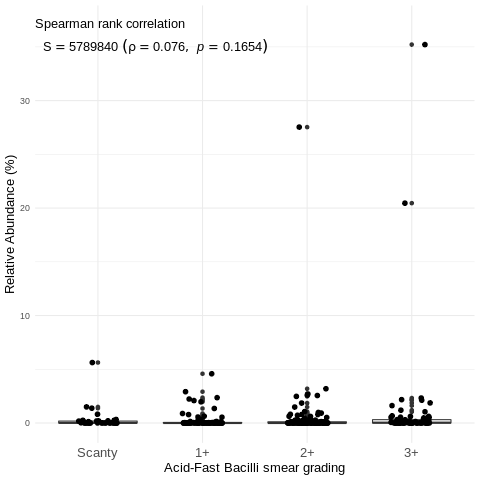

In [17]:
%%R
mycobacterium_asv_afb_annotation <- c(c("Spearman~rank~correlation"), 
                               paste0("~~S ==", round(mycobacterium_asv_afb_test$statistic), 
                                      "~(list(italic(rho)== ", round(mycobacterium_asv_afb_test$estimate,3),
                                      ",~italic(p)== ", round(mycobacterium_asv_afb_test$p.value,4), "))"))

mycobacterium_asv_afb_plot <- ggplot(data=mycobacterium_asv_afb, aes(x=smear_grading, y=Mycobacterium_asv)) + 
                              geom_boxplot() + 
                              geom_jitter(size=2, position=position_jitter(0.2)) + 
                              annotate("text", label=mycobacterium_asv_afb_annotation, x=-Inf, y=c(37,35), 
                                       hjust=0, parse=TRUE, size=4.5) +
                              labs(x="Acid-Fast Bacilli smear grading", y="Relative Abundance (%)") +
                              theme_minimal() + 
                              theme(plot.title = element_text(face="bold", hjust=0,size=14),
                                    plot.subtitle = element_text(hjust=0,size=12),
                                    axis.text.x=element_text(size=13), 
                                    axis.title=element_text(size=13))
mycobacterium_asv_afb_plot

There are six samples with highest relative abundances of the most prevalent Mycobacterium ASV. These samples also have high AFB grades. However, there is no significant monotonic relationship between the relative abundance of this ASV and AFB smear grading.

**Whole-metagenome shotgun (WMS) taxonomic profiles**

WMS sequencing has a species-resolution power. Lets check if _Mycobacterium tuberculosis_ was identified:

In [18]:
%%R
wms_mycobacterium_sp <- grep("Mycobacterium",rownames(metaphlan_all_spp_abund_table), value=TRUE)
cat("Mycobacterium species identified by WMS: \n")
wms_mycobacterium_sp

Mycobacterium species identified by WMS: 
[1] "s__Mycobacterium_orygis"                              
[2] "s__Mycobacterium_tuberculosis_bovis_africanum_canetti"


In [19]:
%%R
# Summary of relative abundances
cat("\nSummary of relative abundances: \n")
summary(t(metaphlan_all_spp_abund_table[wms_mycobacterium_sp,]))


Summary of relative abundances: 
 s__Mycobacterium_orygis s__Mycobacterium_tuberculosis_bovis_africanum_canetti
 Min.   : 0.0000         Min.   : 0.0000                                      
 1st Qu.: 0.0000         1st Qu.: 0.0000                                      
 Median : 0.0000         Median : 0.0000                                      
 Mean   : 0.6214         Mean   : 2.1186                                      
 3rd Qu.: 0.0000         3rd Qu.: 0.0211                                      
 Max.   :29.8017         Max.   :75.4613                                      


In [20]:
%%R
mycobacterium_wms_spp_afb <- wms_mapping_ids[colnames(metaphlan_all_spp_abund_table),]
mycobacterium_wms_spp_afb$smear_grading <- factor(patients_clinical_data[mycobacterium_wms_spp_afb$SubjectID,
                                                                         "smear_grading"], 
                                                  levels=c("Scanty","1+","2+","3+"))
mycobacterium_wms_spp_afb$Mycobacterium_tb_bv_afr_can <- t(metaphlan_all_spp_abund_table["s__Mycobacterium_tuberculosis_bovis_africanum_canetti", 
                                                                                         rownames(mycobacterium_wms_spp_afb)])
# Correlation test
mycobacterium_wms_spp_afb_test <- cor.test(mycobacterium_wms_spp_afb$Mycobacterium_tb_bv_afr_can, 
                                           as.numeric(mycobacterium_wms_spp_afb$smear_grading), 
                                           method='spearman', continuity=FALSE, 
                                           conf.level=0.95)

print(mycobacterium_wms_spp_afb_test)


	Spearman's rank correlation rho

data:  mycobacterium_wms_spp_afb$Mycobacterium_tb_bv_afr_can and as.numeric(mycobacterium_wms_spp_afb$smear_grading)
S = 175157, p-value = 0.2302
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.1175282 



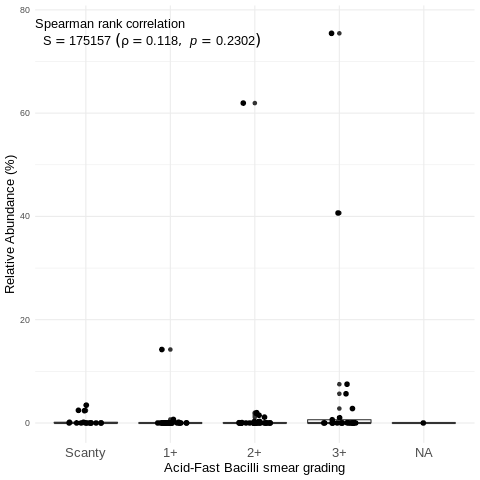

In [21]:
%%R
mycobacterium_wms_afb_annotation <- c(c("Spearman~rank~correlation"), 
                               paste0("~~S ==", round(mycobacterium_wms_spp_afb_test$statistic), 
                                      "~(list(italic(rho)== ", round(mycobacterium_wms_spp_afb_test$estimate,3),
                                      ",~italic(p)== ", round(mycobacterium_wms_spp_afb_test$p.value,4), "))"))

mycobacterium_wms_afb_plot <- ggplot(data=mycobacterium_wms_spp_afb, aes(x=smear_grading, 
                                                                         y=Mycobacterium_tb_bv_afr_can)) + 
                              geom_boxplot() + 
                              geom_jitter(size=2, position=position_jitter(0.2)) + 
                              annotate("text", label=mycobacterium_wms_afb_annotation, x=-Inf, y=c(77,74), 
                                       hjust=0, parse=TRUE, size=4.5) +
                              labs(x="Acid-Fast Bacilli smear grading", y="Relative Abundance (%)") +
                              theme_minimal() + 
                              theme(plot.title = element_text(face="bold", hjust=0,size=14),
                                    plot.subtitle = element_text(hjust=0,size=12),
                                    axis.text.x=element_text(size=13), 
                                    axis.title=element_text(size=13))
mycobacterium_wms_afb_plot

**Panel**

[1] 11.805556  5.555556


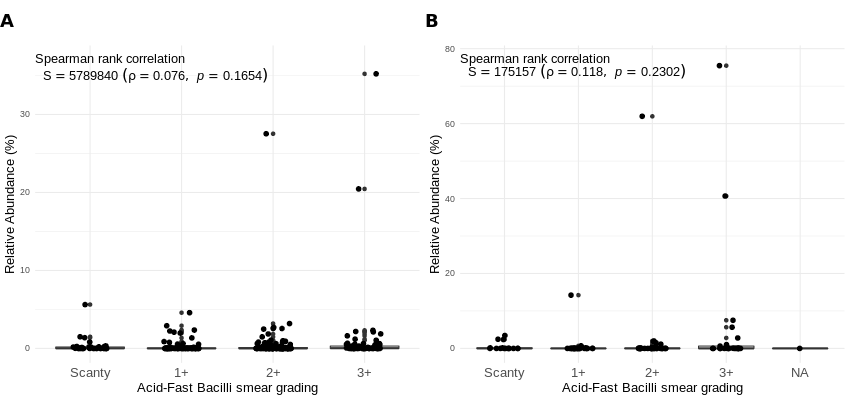

In [22]:
%%R -w 850 -h 400
print(par("din"))
heatmap_layout <- rbind(c(1,1,2,2),
                        c(3,3,4,4))
mycobacterium_asv_spp_by_afb_grading <- grid.arrange(grobs=list(textGrob("A",just="left", x=unit(0, "npc"), 
                                                                             gp=gpar(fontfamily="Roboto Condensed",fontsize=18, fontface="bold")),
                                                                    textGrob("B",just="left", x=unit(0, "npc"), 
                                                                             gp=gpar(fontfamily="Roboto Condensed",fontsize=18, fontface="bold")),
                                                                    mycobacterium_asv_afb_plot, 
                                                                    mycobacterium_wms_afb_plot), 
                                                         layout_matrix=heatmap_layout, heights=c(0.05,0.45))
mycobacterium_asv_spp_by_afb_grading_panel_file <- "./reports/figures/mycobacterium_asv_spp_by_afb_grading.svg"
ggsave(mycobacterium_asv_spp_by_afb_grading_panel_file,mycobacterium_asv_spp_by_afb_grading, 
       width=11.81, height=6.944)